In [1]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

## Loading and preprocessing 
Note that small letters are meant to denote aromacity (aromatic __rings__), so we do not change the case of the letters and keep them intact.

In [2]:
df=pd.read_csv('BBBP.csv')
a=df['smiles'].apply(len)
df.insert(4, "Length",a)
display(df.head())
print('Frequency of each label')
display(df['p_np'].value_counts())

,num,name,p_np,smiles,Length
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,32
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,40
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,50
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,32
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...,66


Frequency of each label


1    1567
0     483
Name: p_np, dtype: int64

400


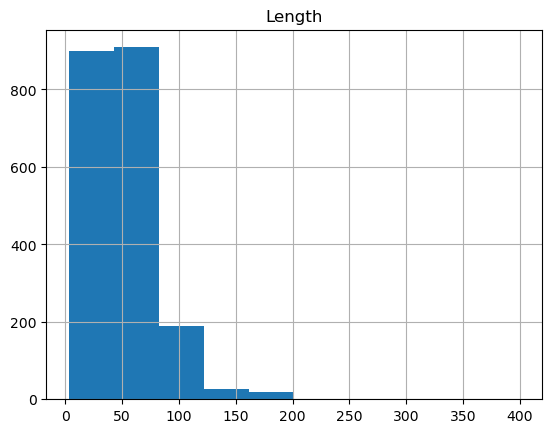

In [3]:
df.hist(column=['Length'])
print(max(df['Length']))

### Tokens and their distrubutions

Tokens are:  ['[' 'C' 'l' ']' '.' '(' ')' 'N' 'O' 'c' '1' '2' '=' '3' '4' 'F' 'n' 'o'
 '@' 'H' 'S' '5' '\\' '/' 's' '#' 'B' 'r' 'I' '+' '-' '6' '7' '8' '9' 'a'
 'P' '%' '0']
######################################################################################
Token frequencies


<Axes: >

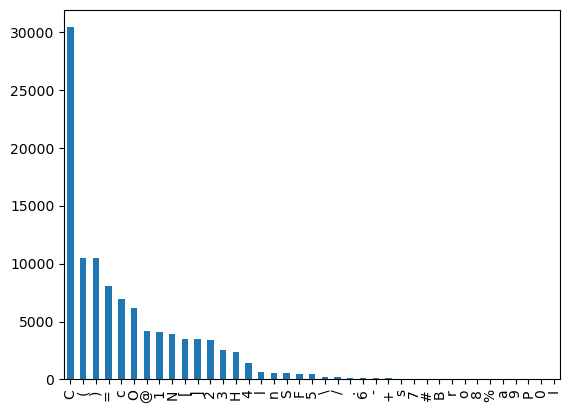

In [18]:
character_array=list(df['smiles'].str.cat())
character_df=pd.DataFrame(character_array)[0]
tokens=character_df.unique()
token_dist=character_df.value_counts()
print("Tokens are: ",tokens)
print('######################################################################################')
print("Token frequencies")
token_dist.plot.bar()

In [6]:
tokens_list= [[x] for x in tokens]
enc = OneHotEncoder(handle_unknown='ignore',sparse=False).fit(tokens_list)

### Dataset classes
One the first one is for the LSTMs, and the second one is for the baseline.
For the baseline, we use the maximum string length of the dataset, then we flatten our encoding and finally, pad it with the necessary number of zeros.

In [31]:
class MyDataset(Dataset):
    def __init__(self, inputs, labels, encoder):
        self.inputs=inputs
        self.labels=labels
        self.encoder=encoder
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        string= self.inputs[index]
        array=[[x] for x in string]
        return self.encoder.transform(array), self.labels[index]

In [8]:
class MyDataset2(Dataset):
    def __init__(self, inputs, labels, encoder, max_length):
        self.inputs=inputs
        self.labels=labels
        self.encoder=encoder
        self.max_length=max_length
    def __len__(self):#max(df['Length'])
        return len(self.labels)

    def __getitem__(self, index):#enc._n_features_outs[0]
        string= self.inputs[index]
        array=[[x] for x in string]
        original=self.encoder.transform(array)
        d=np.zeros((self.max_length-len(string)) *self.encoder._n_features_outs[0])
        padded=np.hstack([original.flatten(),np.zeros((self.max_length-len(string)) *self.encoder._n_features_outs[0]) ]) #Zero padding
        return padded, self.labels[index]

## FC network
As we know the input will be extremely sparse (one-hot with zero padding), we use a simple architecture for the network.

In [9]:
class FC_Network(nn.Module):
    def __init__(self, input_dim,hidden_dim):
        super(FC_Network, self).__init__()
        self.network=nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 6),
            nn.ReLU(),
            nn.Linear(6,1)
        )

    def forward(self, x):
        return self.network(x)

In [10]:
dataset=MyDataset2(list(df['smiles']),list(df['p_np']), enc, max_length=max(df['Length']))

In [12]:
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
model=FC_Network(400*39,24)

train_loader = DataLoader(train_dataset, batch_size=20)
test_loader = DataLoader(test_dataset, batch_size=8)
optimizer=torch.optim.Adam(model.parameters())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_f=nn.BCEWithLogitsLoss()

In [13]:
model = model.to(device)
epochs=10
model.train()
for epoch in range(epochs):
    Sum_loss= 0.0
    print("Epoch: %i"%(epoch+1))
    for i,data in enumerate(train_loader,0):
        (inputs,labels)=data
        inputs=inputs.type(torch.FloatTensor).to(device)
        labels=labels.type(torch.FloatTensor).to(device)
        outputs = model(inputs)

        loss = loss_f(outputs[:,0],labels)
        Sum_loss += loss.item()/len(train_loader)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f'loss_TRAIN ={Sum_loss:.3f}')

Epoch: 1
loss_TRAIN =0.481
Epoch: 2
loss_TRAIN =0.270
Epoch: 3
loss_TRAIN =0.186
Epoch: 4
loss_TRAIN =0.138
Epoch: 5
loss_TRAIN =0.105
Epoch: 6
loss_TRAIN =0.081
Epoch: 7
loss_TRAIN =0.061
Epoch: 8
loss_TRAIN =0.049
Epoch: 9
loss_TRAIN =0.036
Epoch: 10
loss_TRAIN =0.028


### FC-network results on the test set

In [15]:
model.eval()
with torch.no_grad():
    Sum_loss= 0.0
    accuracy=0
    for i,data in enumerate(test_loader,0):
        (inputs,labels)=data
        inputs=inputs.type(torch.FloatTensor).to(device)
        labels=labels.type(torch.FloatTensor).to(device)
        outputs = model(inputs)

        loss = loss_f(outputs[:,0],labels)
        Sum_loss += loss.item()/len(train_loader)
        pred=(1+torch.sign(outputs[:,0]))/2
        accuracy+=np.sum(np.equal(pred.detach().cpu().numpy(),labels.detach().cpu().numpy()))/len(test_dataset)
    print(f'loss_TEST ={Sum_loss:.3f}')
print("Accuracy on test equals: ", accuracy)

loss_TEST =0.102
Accuracy on test equals:  0.8975609756097565


## LSTM
Architecture: WE have two main choices: First is padding the sequence again, and the second is using the last m outputs, where m is less than or equal to the minimum sequnece length (3) with a batch size of 1. We use the second method, and simulations show that m=1 is actually the best.


In [139]:
class LSTM_FC(nn.Module):
    def __init__(self, fc_input_dim, fc_hidden_dim, input_size, hidden_size, num_layers=1, bias=True, batch_first=False, dropout=0.0, bidirectional=False):
        super(LSTM_FC, self).__init__()
        self.LSTM=nn.LSTM(input_size, hidden_size, num_layers, bias, batch_first, dropout, bidirectional)
        self.fc_network=nn.Sequential(
            nn.Linear(fc_input_dim, fc_hidden_dim),
            nn.ReLU(),
            nn.Linear(fc_hidden_dim, 6),
            nn.ReLU(),
            nn.Linear(6,1)
        )
        self.bidir=bidirectional

    def forward(self, x):
        output, hidden=self.LSTM(x)
        #print(output.shape)
        #print(output[:,-1].shape)
        return self.fc_network(torch.flatten(output[:,-1],start_dim=1))

### Model parameters
The most important one is the dropout value. As the dataset in unbalanced, the accuracy without training is about 75%. With dropouts of 0.1 and 0.3, We see that some runs get a good accuracy, and some give the 75% value. But for dropout=0.2, the results are more stable

In [156]:
model=LSTM_FC(30,15,input_size=enc._n_features_outs[0], hidden_size=30, num_layers=2, dropout=0.2, batch_first=True).to(device)
dataset=MyDataset(list(df['smiles']),list(df['p_np']), enc)

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=1)
test_loader = DataLoader(test_dataset, batch_size=1)
optimizer=torch.optim.Adam(model.parameters())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_f=nn.BCEWithLogitsLoss()

model.train()
for epoch in range(epochs):
    Sum_loss= 0.0
    print("Epoch: %i"%(epoch+1))
    for i,data in enumerate(train_loader,0):
        (inputs,labels)=data
        inputs=inputs.type(torch.FloatTensor).to(device)
        labels=labels.type(torch.FloatTensor).to(device)
        outputs = model(inputs)

        loss = loss_f(outputs[:,0],labels)
        Sum_loss += loss.item()/len(train_loader)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f'loss_TRAIN ={Sum_loss:.3f}')

Epoch: 1
loss_TRAIN =0.546
Epoch: 2
loss_TRAIN =0.406
Epoch: 3
loss_TRAIN =0.375
Epoch: 4
loss_TRAIN =0.351
Epoch: 5
loss_TRAIN =0.325
Epoch: 6
loss_TRAIN =0.311
Epoch: 7
loss_TRAIN =0.301
Epoch: 8
loss_TRAIN =0.290
Epoch: 9
loss_TRAIN =0.288
Epoch: 10
loss_TRAIN =0.269


In [146]:
model.eval()
with torch.no_grad():
    Sum_loss= 0.0
    accuracy=0
    for i,data in enumerate(test_loader,0):
        (inputs,labels)=data
        inputs=inputs.type(torch.FloatTensor).to(device)
        labels=labels.type(torch.FloatTensor).to(device)
        outputs = model(inputs)

        loss = loss_f(outputs[:,0],labels)
        Sum_loss += loss.item()/len(train_loader)
        pred=(1+torch.sign(outputs[:,0]))/2
        accuracy+=np.sum(np.equal(pred.detach().cpu().numpy(),labels.detach().cpu().numpy()))/len(test_dataset)
    print(f'loss_TEST ={Sum_loss:.3f}')
print("Accuracy on test equals: ", accuracy)

loss_TEST =0.039
Accuracy on test equals:  0.8634146341463421


### 10-fold cross validation

In [159]:
K=10
epochs=10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for k in range(K):
    model=LSTM_FC(30,15,input_size=enc._n_features_outs[0], hidden_size=30, num_layers=2, dropout=0.2, batch_first=True).to(device)
    dataset=MyDataset(list(df['smiles']),list(df['p_np']), enc)
    
    train_size = int((1-1/K) * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=1)
    test_loader = DataLoader(test_dataset, batch_size=1)
    optimizer=torch.optim.Adam(model.parameters())

    loss_f=nn.BCEWithLogitsLoss()

    model.train()
    for epoch in range(epochs):
        Sum_loss=0
        for i,data in enumerate(train_loader,0):
            (inputs,labels)=data
            inputs=inputs.type(torch.FloatTensor).to(device)
            labels=labels.type(torch.FloatTensor).to(device)
            outputs = model(inputs)
            loss = loss_f(outputs[:,0],labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
    model.eval()
    with torch.no_grad():
        accuracy=0
        for i,data in enumerate(test_loader,0):
            (inputs,labels)=data
            inputs=inputs.type(torch.FloatTensor).to(device)
            labels=labels.type(torch.FloatTensor).to(device)
            outputs = model(inputs)

            pred=(1+torch.sign(outputs[:,0]))/2
            accuracy+=np.sum(np.equal(pred.detach().cpu().numpy(),labels.detach().cpu().numpy()))/len(test_dataset)
    print("Accuracy on test equals: ", accuracy)

Accuracy on test equals:  0.8634146341463421
Accuracy on test equals:  0.7951219512195128
Accuracy on test equals:  0.8292682926829275
Accuracy on test equals:  0.8829268292682934
Accuracy on test equals:  0.9219512195121958
Accuracy on test equals:  0.8390243902439031
Accuracy on test equals:  0.8341463414634153
Accuracy on test equals:  0.8390243902439031
Accuracy on test equals:  0.8292682926829275
Accuracy on test equals:  0.8487804878048787


The average accuracy on validation set is __85%__

## BiLSTM
### Model parameters
Again, the dropout=0.2 and m=1 is the best. Again, a batch size of 1 is chosen.

In [150]:
model=LSTM_FC(60,15,input_size=enc._n_features_outs[0], hidden_size=30, num_layers=2, dropout=0.2, batch_first=True, bidirectional=True).to(device)
dataset=MyDataset(list(df['smiles']),list(df['p_np']), enc, )

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=1)
test_loader = DataLoader(test_dataset, batch_size=1)
optimizer=torch.optim.Adam(model.parameters())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_f=nn.BCEWithLogitsLoss()

for epoch in range(epochs):
    Sum_loss= 0.0
    print("Epoch: %i"%(epoch+1))
    for i,data in enumerate(train_loader,0):
        (inputs,labels)=data
        inputs=inputs.type(torch.FloatTensor).to(device)
        labels=labels.type(torch.FloatTensor).to(device)
        #print(inputs.shape)
        #print(labels)
        outputs = model(inputs)

        loss = loss_f(outputs[:,0],labels)
        Sum_loss += loss.item()/len(train_loader)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f'loss_TRAIN ={Sum_loss:.3f}')

model.eval()
with torch.no_grad():
    Sum_loss= 0.0
    accuracy=0
    for i,data in enumerate(test_loader,0):
        (inputs,labels)=data
        inputs=inputs.type(torch.FloatTensor).to(device)
        labels=labels.type(torch.FloatTensor).to(device)
        outputs = model(inputs)

        loss = loss_f(outputs[:,0],labels)
        Sum_loss += loss.item()/len(train_loader)
        pred=(1+torch.sign(outputs[:,0]))/2
        accuracy+=np.sum(np.equal(pred.detach().cpu().numpy(),labels.detach().cpu().numpy()))/len(test_dataset)
    print(f'loss_TEST ={Sum_loss:.3f}')
print("Accuracy on test equals: ", accuracy)

Epoch: 1
loss_TRAIN =0.496
Epoch: 2
loss_TRAIN =0.410
Epoch: 3
loss_TRAIN =0.382
Epoch: 4
loss_TRAIN =0.378
Epoch: 5
loss_TRAIN =0.390
Epoch: 6
loss_TRAIN =0.351
Epoch: 7
loss_TRAIN =0.338
Epoch: 8
loss_TRAIN =0.326
Epoch: 9
loss_TRAIN =0.316
Epoch: 10
loss_TRAIN =0.335
loss_TEST =0.031
Accuracy on test equals:  0.8682926829268299


### 10-fold cross validation

In [160]:
K=10
epochs=10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for k in range(K):
    model=LSTM_FC(60,15,input_size=enc._n_features_outs[0], hidden_size=30, num_layers=2, dropout=0.2, batch_first=True, bidirectional=True).to(device)
    dataset=MyDataset(list(df['smiles']),list(df['p_np']), enc, )
    
    train_size = int((1-1/K) * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=1)
    test_loader = DataLoader(test_dataset, batch_size=1)
    optimizer=torch.optim.Adam(model.parameters())

    loss_f=nn.BCEWithLogitsLoss()

    model.train()
    for epoch in range(epochs):
        for i,data in enumerate(train_loader,0):
            (inputs,labels)=data
            inputs=inputs.type(torch.FloatTensor).to(device)
            labels=labels.type(torch.FloatTensor).to(device)
            outputs = model(inputs)
            loss = loss_f(outputs[:,0],labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    model.eval()
    with torch.no_grad():
        accuracy=0
        for i,data in enumerate(test_loader,0):
            (inputs,labels)=data
            inputs=inputs.type(torch.FloatTensor).to(device)
            labels=labels.type(torch.FloatTensor).to(device)
            outputs = model(inputs)

            pred=(1+torch.sign(outputs[:,0]))/2
            accuracy+=np.sum(np.equal(pred.detach().cpu().numpy(),labels.detach().cpu().numpy()))/len(test_dataset)
    print("Accuracy on validation equals: ", accuracy)

Accuracy on validation equals:  0.8487804878048787
Accuracy on validation equals:  0.8000000000000006
Accuracy on validation equals:  0.8682926829268299
Accuracy on validation equals:  0.8390243902439031
Accuracy on validation equals:  0.8000000000000006
Accuracy on validation equals:  0.8195121951219518
Accuracy on validation equals:  0.8634146341463421
Accuracy on validation equals:  0.8634146341463421
Accuracy on validation equals:  0.8536585365853665
Accuracy on validation equals:  0.8439024390243909


The average accuracy on validation set is __84%__

## Conclusion
Both architectures reach a similar maximum accuracy, but the lower bound on accuracy is a bit better for the BiLSTM, becuase it doesnt differ from which side we read the molecule formula. But the average accuracy of BiLSTM is lower, which might be becuase of the dataset challenges that do not enable us to use its full potential (output cropping for the fc network in particular)